In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [26]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

In [27]:
directory = "./synthetic-data"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.split(".")[-1]=="txt"]

print(files)

['background.txt', 'target_30.txt', 'target_45.txt', 'target_0.txt', 'target_15.txt']


In [28]:
dobs_dict = {}

for f in files: 
    key = f.split(".")[0]
    dobs_dict[key] = np.loadtxt(f"{directory}/{f}")

In [29]:
rx_times = np.logspace(np.log10(1e-4), np.log10(8e-3), 27)

tx_height = np.r_[30]

rx_x = (np.linspace(-500, 500, 51) + 5)
rx_y = np.r_[0]
rx_z = tx_height

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
# rx_x

source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)


In [30]:
data_dict = {}

for key, value in dobs_dict.items(): 
    data_dict[key] = Data(survey=full_survey, dobs=value, relative_error=0.05)

In [31]:
rho_back = 200
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_dips = np.r_[0, 15, 30, 45]
# target_z = -70 + 40/2*np.r_[-1, 1]

# create survey

In [32]:
tx_height = np.r_[30]
rx_z = tx_height


In [33]:
rx_times = np.logspace(np.log10(1e-4), np.log10(8e-3), 27)
rx_loc = np.r_[0, 0, tx_height]

rx1d = tdem.receivers.PointMagneticFluxTimeDerivative(rx_loc, rx_times, orientation="z")
src1d = tdem.sources.CircularLoop(
    receiver_list=[rx1d], location=rx_loc, orientation="z", radius=10, 
    waveform=tdem.sources.StepOffWaveform()
)

survey1d = tdem.Survey([src1d])


In [34]:
true_rho = np.r_[rho_back, rho_target, rho_back]
true_model = np.log(1./true_rho)
true_thicknesses = np.r_[sorted(np.abs(target_z))]
mesh_true = discretize.TensorMesh([(np.r_[true_thicknesses, true_thicknesses[-1]])], origin="0")

true_simulation = tdem.Simulation1DLayered(
    survey=survey1d, thicknesses=true_thicknesses, sigmaMap=maps.ExpMap(mesh_true)
)

In [35]:
true_background = np.log(1./rho_back)*np.ones(3)
background_data = true_simulation.dpred(true_background)
target_data = true_simulation.dpred(true_model)

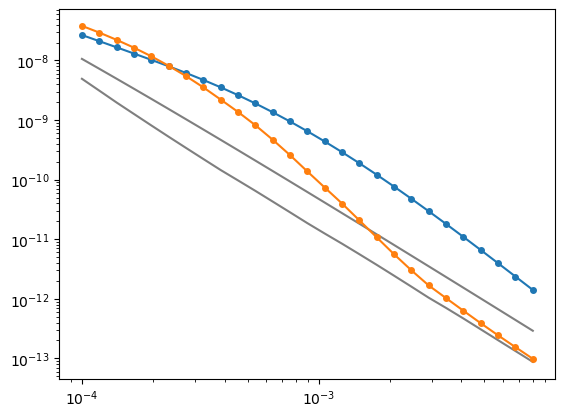

In [37]:
# key = "target_15"
# ind = 16
# src = full_survey.source_list[ind]

plt.loglog(rx_times, -background_data, "k", alpha=0.5)
plt.loglog(rx_times, -target_data, "C0-o", ms=4)

ind=10
src = source_list[ind]
rx = src.receiver_list[0]
plt.loglog(rx_times, -data_dict["background"][src, rx], "k", alpha=0.5)
plt.loglog(rx_times, -data_dict["target_0"][src, rx], "C1-o", ms=4)

In [12]:
# octree_mesh = discretize.load_mesh("./synthetic-data/treemesh.json")

# octree_mesh = discretize.load_mesh()

In [41]:
cs = 10
core_region = 200
npad = 15
padding_factor = 1.3

thicknesses1d = discretize.utils.unpack_widths(
    [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
)

In [42]:
np.sum(thicknesses1d)


np.float64(2374.7220306106005)

In [43]:
tx_height

array([30])

In [44]:
np.r_[0, 0, tx_height]

array([ 0,  0, 30])

In [45]:
# set up 1D inversion 

key = "target_0"
ind = 16
relative_error=0.05
# norms = [2, 2]
alpha_s = 1e-3
alpha_x = 1
rho_back = 500 

# def create inv

src = full_survey.source_list[ind]
rx = src.receiver_list[0]

rx_sounding = tdem.receivers.PointMagneticFluxTimeDerivative(
    locations=np.r_[0, 0, tx_height], times=rx.times, orientation=rx.orientation
)
src_sounding = tdem.sources.CircularLoop(
    receiver_list=[rx_sounding], location=np.r_[0, 0, tx_height], orientation=src.orientation, 
    radius=src.radius, 
    waveform=tdem.sources.StepOffWaveform()
)
survey_sounding = tdem.Survey([src_sounding])
mesh_invert = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")

sim1d = tdem.Simulation1DLayered(
    survey=survey_sounding, thicknesses=thicknesses1d, sigmaMap=maps.ExpMap(mesh_invert)
)

data_invert = Data(survey_sounding, dobs=data_dict[key][src, rx], relative_error=relative_error)

dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
reg = regularization.WeightedLeastSquares(
    mesh_invert, alpha_s=alpha_s, alpha_x=alpha_x, 
    reference_model=np.log(1./rho_back),
    # norms=norms
)

opt = optimization.InexactGaussNewton(maxIter=30, tolCG=1e-3)
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=2)

# Update the preconditionner
update_Jacobi = directives.UpdatePreconditioner()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputDictEveryIteration(
    saveOnDisk=False, directory=f"./synthetic-invs-1d/{key}", name=f"inv-dict-{rx.locations[0,0]}"
)

# # Directives for the IRLS
# update_IRLS = directives.Update_IRLS(
#     max_irls_iterations=30, minGNiter=1, coolEpsFact=1.5, update_beta=True
# )

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Add sensitivity weights
# sensitivity_weights = directives.UpdateSensitivityWeights()

target_misfit = directives.TargetMisfit()

# The directives are defined as a list.
directives_list = [
    # sensitivity_weights,
    starting_beta,
    save_iteration,
    target_misfit,
    # update_IRLS,
    # update_jacobi,
]

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

In [46]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)


Running inversion with SimPEG v0.24.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.32e+02  7.18e+03  0.00e+00  7.18e+03    7.22e+02      0              
   1  6.32e+02  4.19e+03  2.85e-01  4.37e+03    7.16e+02      1              
   2  6.32e+02  3.06e+03  5.71e-01  3.42e+03    2.87e+03      1              
   3  6.32e+02  2.43e+03  9.77e-01  3.05e+03    3.67e+03      0              
   4  6.32e+02  1.84e+03  9.33e-01  2.43e+03    2.27e+03      0              
   5  6.32e+02  1.58e+03  9.04e-01  2.15e+03    4.11e+02      0   Skip BFGS  
   6  6.32e+02  1.56e+0

In [47]:
np.exp(mopt)

array([0.01157174, 0.01456351, 0.0212014 , 0.02986097, 0.02982532,
       0.01917271, 0.01044653, 0.00594603, 0.00376458, 0.00264752,
       0.00203   , 0.00166383, 0.00143374, 0.00128227, 0.0011787 ,
       0.00110562, 0.00105268, 0.00101345, 0.00098384, 0.0009612 ,
       0.00094119, 0.0009226 , 0.00090732, 0.00089771, 0.00089619,
       0.00090447, 0.00092467, 0.00096262, 0.00102506, 0.00111768,
       0.00124954, 0.00143352, 0.00166936, 0.00190558, 0.00203304,
       0.0020702 ])

In [48]:
iterations = list(save_iteration.outDict.keys())

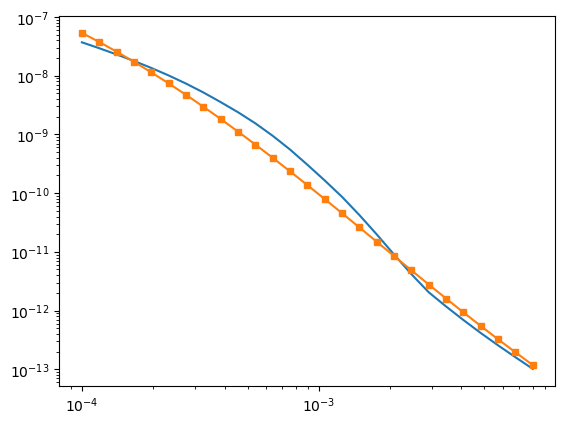

In [49]:
key = "target_15"
ind = 16
src = full_survey.source_list[ind]

# plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
# plt.loglog(rx_times, -data_dict[key][src, rx], "C0o", ms=4)
plt.loglog(rx_times, -dmis.data.dobs)
plt.loglog(rx_times, -save_iteration.outDict[iterations[-1]]["dpred"], "C1-s", ms=4)

(200.0, 0.0)

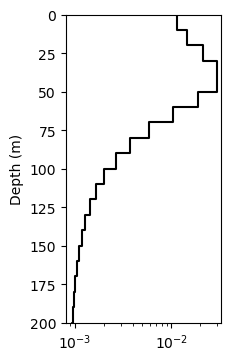

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="k", label="recovered"
)
ax.set_ylim([200, 0])


In [ ]:

rx = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, tx_height], times=rx_times, orientation="z"
)

src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, tx_height], radius=10, receiver_list=[rx_z], #waveform=waveform
)

survey_invert = tdem.Survey([src])

sim1d = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=maps.ExpMap(mesh_invert)
)

In [22]:
def get_sim():
    # set up survey
    rx_times = np.logspace(np.log10(1e-4), np.log10(8e-3), 27)
    
    source_list = []

    for i in range(rx_locs.shape[0]): 
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)
    
    survey = tdem.Survey(source_list)

    # create simulation 
    time_steps = [
        (1e-5, 40), (3e-5, 20), (1e-4, 20), (3e-4, 20)
    ]   
    msh = mesh.copy()
    active_cells_map = maps.InjectActiveCells(msh, msh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))

    global_sim = tdem.simulation.Simulation3DElectricField(
        mesh=msh,
        survey=survey,
        time_steps=time_steps,
        solver=Solver,
        sigmaMap=maps.ExpMap() * active_cells_map
    )
    return global_sim

In [24]:
def run_simulation(key):
    print(f"Starting {key}")
    filename = f"./synthetic-data/{key}.txt"
    t = time.time()
    model = log_conductivity_models[key]
    sim = get_sim()
    dpred = sim.dpred(model)
    np.savetxt(filename, dpred)
    elapsed = time.time() - t
    print(f".... done. {filename}. Elapsed time = {elapsed:1.2e}s \n")
    return key, dpred

In [25]:
dpred_dict = {}

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(run_simulation, key) for key in model_keys]
    for future in as_completed(futures):
        key, dpred = future.result()
        dpred_dict[key] = dpred

Starting background
Starting target_0Starting target_15Starting target_30Starting target_45





/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/base/base_mesh.py:197: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  return cls(**items)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/base/base_mesh.py:197: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  return cls(**items)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/base/base_mesh.py:197: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes y

.... done. ./synthetic-data/target_15.txt. Elapsed time = 2.56e+03s
.... done. ./synthetic-data/target_45.txt. Elapsed time = 2.59e+03s
.... done. ./synthetic-data/target_30.txt. Elapsed time = 2.62e+03s
.... done. ./synthetic-data/background.txt. Elapsed time = 2.66e+03s
.... done. ./synthetic-data/target_0.txt. Elapsed time = 2.72e+03s


In [25]:
# %%time 

# dpred_dict = {}

# for key in model_keys:
#     print(f"Starting {key}")
#     filename = f"./synthetic-data/{key}.txt"
#     t = time.time()
#     model = log_conductivity_models[key]
#     sim = get_sim()
#     dpred = sim.dpred(model)
#     np.savetxt(filename, dpred)
#     dpred_dict[key] = dpred
#     print(f".... done. {filename}. Elapsed time = {time.time()-t:1.2e}s")
    
# # sim.join()

Starting background


/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),


.... done. ./synthetic-data/background.txt. Elapsed time = 1.76e+03s
Starting target_0
.... done. ./synthetic-data/target_0.txt. Elapsed time = 1.80e+03s
Starting target_15
.... done. ./synthetic-data/target_15.txt. Elapsed time = 1.86e+03s
Starting target_30
.... done. ./synthetic-data/target_30.txt. Elapsed time = 1.89e+03s
Starting target_45
.... done. ./synthetic-data/target_45.txt. Elapsed time = 1.72e+03s
CPU times: user 6h 20min 28s, sys: 3h 55min 57s, total: 10h 16min 26s
Wall time: 2h 30min 18s


In [26]:
dpred_dict

{'target_15': array([-6.66575190e-09, -4.50859748e-09, -3.04416360e-09, ...,
        -2.19878855e-13, -1.42218586e-13, -9.21836100e-14]),
 'target_45': array([-4.92056328e-09, -3.16125276e-09, -2.04527534e-09, ...,
        -2.05933452e-13, -1.35058968e-13, -8.85423570e-14]),
 'target_30': array([-5.03128876e-09, -3.28451014e-09, -2.16314351e-09, ...,
        -2.08874772e-13, -1.36578256e-13, -8.93195877e-14]),
 'background': array([-4.93578829e-09, -3.12332336e-09, -1.97233983e-09, ...,
        -2.02236523e-13, -1.33119223e-13, -8.75355799e-14]),
 'target_0': array([-8.78647908e-09, -6.06476858e-09, -4.15458716e-09, ...,
        -2.23144092e-13, -1.43924532e-13, -9.30460608e-14])}

In [28]:
rx_locs.shape

(51, 3)

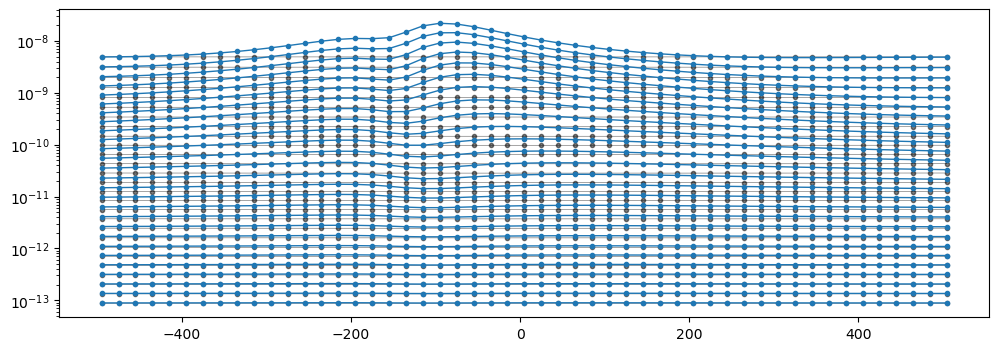

In [44]:
key = model_keys[4]
rx_times = np.logspace(np.log10(1e-4), np.log10(8e-3), 27)

n_sources = rx_locs.shape[0]
n_rxtimes = len(rx_times)

fig, ax = plt.subplots(1, 1, figsize = (12, 4)) 

ax.semilogy(rx_x, -dpred_dict[model_keys[0]].reshape(n_sources, n_rxtimes), "-k", marker=".", lw=0.5, alpha=0.5);
ax.semilogy(rx_x, -dpred_dict[key].reshape(n_sources, n_rxtimes), "-C0", marker=".", lw=1);


In [49]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for i, key in enumerate(model_keys):
    


['background', 'target_0', 'target_15', 'target_30', 'target_45']